# Project 2: Regression

## Backstory:

Using information we scrape from the web, build linear regression models from which we can learn about movies, *sports*, or categories.

In [17]:
from bs4 import BeautifulSoup
import time, os
import numpy as np
import pandas as pd
import random
# import requests # not needed, since we are using Selenium
from fake_useragent import UserAgent
from selenium import webdriver
# from selenium.webdriver.common.keys import Keys

In [ ]:
# Set up Selenium
chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

# Set random user agent
ua = UserAgent()
user_agent = {'User-agent': ua.random}
print(user_agent)


# Load first ranking page:

url = "https://www.atptour.com/en/rankings/singles"

driver = webdriver.Chrome(chromedriver)
driver.get(url)
soup = BeautifulSoup(driver.page_source, 'html.parser')

## TODO: This covers 1-100 rankings; I want to get to 500, possibly.

### Overview rankings table scrape:

In [ ]:
ranks=[]
for element in soup.find_all('td', class_='rank-cell'):
    ranks.append(int(element.text.strip()))

players=[]
for element in soup.find_all('td', class_='player-cell'):
    players.append(element.text.strip('\n').lstrip())
    
countries=[]
for element in soup.find_all('td', class_='country-cell'):
    countries.append(element.find('img').get('alt'))
    
ages=[]
for element in soup.find_all('td', class_='age-cell'):
    ages.append(int(element.text.strip()))

points=[]
for element in soup.find_all('td', class_='points-cell'):
    points.append(element.text.strip())  

tourns = []
for element in soup.find_all('td', class_='tourn-cell'):
    tourns.append(element.text.strip())

player_urls = []
for element in soup.find_all('td', class_='player-cell'):
    player_urls.append(element.find('a').get('href'))

In [ ]:
# for additional rows, the URLs will have the format: https://www.atptour.com/en/rankings/singles?rankDate=2020-09-28&rankRange=101-200

In [ ]:
tennis_dict = {'Rank':ranks, 'Name':players, 'Country':countries, 'Age':ages, "Points":points, "Tournaments":tourns, "URI":player_urls}
tennis_df = pd.DataFrame(tennis_dict)
tennis_df['Points'] = tennis_df['Points'].str.replace(',', '').astype(int)
tennis_df['Tournaments'] = tennis_df['Tournaments'].str.replace(',', '').astype(int)

tennis_df.head()

### Per player data scrape:
(takes ~3 min on a low latency connection, randomized connection times)

In [ ]:
list_of_dicts = []
first_run = True

for num in range(0,100):
    # Load URL in Selenium
    uri = "https://www.atptour.com"+player_urls[num].replace("overview", "player-stats")
    driver.get(uri)
    if first_run: # adds extra time for the first page load
        time.sleep(3) # note, you may be prompted to complete a CAPTCHA here
    else:
        time.sleep(0.25+random.random())
    
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    stats = {}
    
    try:
        # Scrape left-hand table
        table = soup.find('table', class_ = "mega-table")
        rows = [row for row in table.find_all('tr')]
        rows.pop(0) # removes table header
        
        for row in rows:
            items = row.find_all('td')
            if items[1].text.strip()[-1] == "%":
                stats[items[0].text.strip()] = float(int(items[1].text.strip().replace('%', ''))/100.0)
            else:
                stats[items[0].text.strip()] = int(items[1].text.strip().replace(',', ''))

        # Scrape right-hand table
        table = table.find_next_sibling()
        rows = [row for row in table.find_all('tr')]
        rows.pop(0) # Removes table header

        for row in rows:
            items = row.find_all('td')
            if items[1].text.strip()[-1] == "%":
                stats[items[0].text.strip()] = float(int(items[1].text.strip().replace('%', ''))/100.0)
            else:
                stats[items[0].text.strip()] = int(items[1].text.strip().replace(',', ''))

    except AttributeError:
        print("This page, "+ player_urls[num].replace("overview", "player-stats") +", can't be loaded right now.")
        list_of_dicts.append(np.nan) # append NaN on failure to keep row index in sync
        continue

    try:
        uri = "https://www.atptour.com"+player_urls[num].replace("player-stats", "overview")
        driver.get(uri)
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # Scrape WL and winnings stats
        row = soup.find('table', class_ = "players-stats-table").tbody.find_all('tr')[1]
        wins   = int(row.find_all('td')[2].find_all('div')[0].text.strip().split('-')[0])
        losses = int(row.find_all('td')[2].find_all('div')[0].text.strip().split('-')[1])

        stats["Career Wins"] = wins
        stats["Career Losses"] = losses
        stats["Career WL Ratio"] = float(wins/losses)

        life_winnings = row.find_all('td')[4].find_all('div')[0].text.strip()
        stats["Lifetime Prize"] = int(life_winnings.strip('$').replace(',', ''))
    
    except AttributeError:
        print("This WL page, "+ player_urls[num] +", can't be loaded right now.")
        # list_of_dicts.append(np.nan) # append NaN on failure to keep row index in sync
        continue

    first_run = False # reduces wait to random amount for runs after the first one

    list_of_dicts.append(stats)

In [ ]:
tennis_details_df = pd.DataFrame(list_of_dicts) # convert dicts into "stats/details" dataframe
tennis_details_df.head()

In [ ]:
# Merge overall leaderboard with columns from each player's individual stats page:
tennis_df = pd.concat([tennis_df, tennis_details_df], axis = 1)
tennis_df.tail()

In [ ]:
# Check that we've converted all percentages to floats, and comma-delineated strings to ints:
print(tennis_df.isnull().sum().sum()) # If this equals 0, we're happy with our scrape.
# tennis_df.dropna(axis = 0) # Not needed for current scrape; only if NaNs present.
print(tennis_df.dtypes)

tennis_df.tail()

### Pickle the summary data (not per-year just yet):

In [18]:
# tennis_df.to_pickle("./tennis.pkl")
tennis_df=pd.read_pickle("./tennis.pkl")

In [4]:
# Assume name as unique index
# Drop Country, URI; try to predict Rank.
tennis_df_subset = tennis_df.set_index("Name").drop(['Country', 'URI', 'Career Wins', 'Career Losses'], axis = 1)
tennis_df_subset.head()
print(tennis_df_subset.dtypes)

Rank                             int64
Age                              int64
Points                           int64
Tournaments                      int64
Aces                             int64
Double Faults                    int64
1st Serve                      float64
1st Serve Points Won           float64
2nd Serve Points Won           float64
Break Points Faced               int64
Break Points Saved             float64
Service Games Played             int64
Service Games Won              float64
Total Service Points Won       float64
1st Serve Return Points Won    float64
2nd Serve Return Points Won    float64
Break Points Opportunities       int64
Break Points Converted         float64
Return Games Played              int64
Return Games Won               float64
Return Points Won              float64
Total Points Won               float64
Career WL Ratio                float64
Lifetime Prize                   int64
dtype: object


### Time to get some year-over-year values:
(This is less data per page, so I'm trying to scrape a little faster here.)

In [ ]:
# 2016-2019 data: try/catch

# Sample URI:
# https://www.atptour.com/en/players/novak-djokovic/d643/player-stats?year=2016

# Two intra-year pairings are all that's needed, but there are lots of zeroes for which players didn't play or weren't ranked. Here we can have up to 3 intra-year consecutive pairings, for some, but not all ranked players.

driver = webdriver.Chrome(chromedriver)
list_of_dicts = []
first_run = True

for index, row in tennis_df.iterrows():
    uri = "https://www.atptour.com"+row['URI']
    player_name = row['Name']
    for year in range(2016,2020):
        # Load URL in Selenium
        uri_year = uri.replace("overview", "player-stats")+"?year="+str(year)
        driver.get(uri_year)
        if first_run: # adds extra time for the first page load
            time.sleep(30)
        else:
            time.sleep(0.15 + random.random())

        soup = BeautifulSoup(driver.page_source, 'html.parser')

        try:
            # Scrape left-hand table
            table = soup.find('table', class_ = "mega-table")
            rows = [row for row in table.find_all('tr')]
            rows.pop(0) # removes table header
            stats = {}
            stats['Name'] = player_name
            stats['Year'] = year

            for row in rows: # inner for loop to examine scrape dpage, not in parent df
                items = row.find_all('td')
                if items[1].text.strip()[-1] == "%":
                    stats[items[0].text.strip()] = float(int(items[1].text.strip().replace('%', ''))/100.0)
                else:
                    stats[items[0].text.strip()] = int(items[1].text.strip().replace(',', ''))

            # Scrape right-hand table
            table = table.find_next_sibling()
            rows = [row for row in table.find_all('tr')]
            rows.pop(0) # Removes table header

            for row in rows:
                items = row.find_all('td')
                if items[1].text.strip()[-1] == "%":
                    stats[items[0].text.strip()] = float(int(items[1].text.strip().replace('%', ''))/100.0)
                else:
                    stats[items[0].text.strip()] = int(items[1].text.strip().replace(',', ''))

        except AttributeError:
            print("Stats for "+ uri_year + " in "+str(year)+" can't be loaded right now.")
            # append something useful, maybe NANs here.

        if stats['Service Games Played'] != 0: # check if non-empty
            list_of_dicts.append(stats)

        first_run = False

In [19]:
tennis_annual_df = pd.DataFrame(list_of_dicts) # convert dicts into "stats/details" dataframe
print(tennis_annual_df.shape)
zero_count = tennis_annual_df['Service Games Played'] == 0
zero_count.shape

NameError: name 'list_of_dicts' is not defined

In [20]:
# tennis_annual_df.to_pickle("./tennis_annual.pkl")

tennis_annual_df=pd.read_pickle("./tennis_annual.pkl")

### Visualize what we have so far:

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [22]:
# Prioritize Win/Loss ratio as the target column:

tennis_o_wlratio = tennis_df_subset[['Career WL Ratio','Points','Aces','Tournaments','Double Faults',
       '1st Serve', '1st Serve Points Won', '2nd Serve Points Won',
       'Break Points Faced', 'Break Points Saved', 'Service Games Played',
       'Service Games Won', 'Total Service Points Won',
       '1st Serve Return Points Won', '2nd Serve Return Points Won',
       'Break Points Opportunities', 'Break Points Converted',
       'Return Games Played', 'Return Games Won', 'Return Points Won',
       'Total Points Won']]

# Prioritize lifetime Prize Money as the target column:
tennis_o_prize = tennis_df_subset[['Lifetime Prize','Points','Aces','Tournaments','Double Faults',
       '1st Serve', '1st Serve Points Won', '2nd Serve Points Won',
       'Break Points Faced', 'Break Points Saved', 'Service Games Played',
       'Service Games Won', 'Total Service Points Won',
       '1st Serve Return Points Won', '2nd Serve Return Points Won',
       'Break Points Opportunities', 'Break Points Converted',
       'Return Games Played', 'Return Games Won', 'Return Points Won',
       'Total Points Won']]

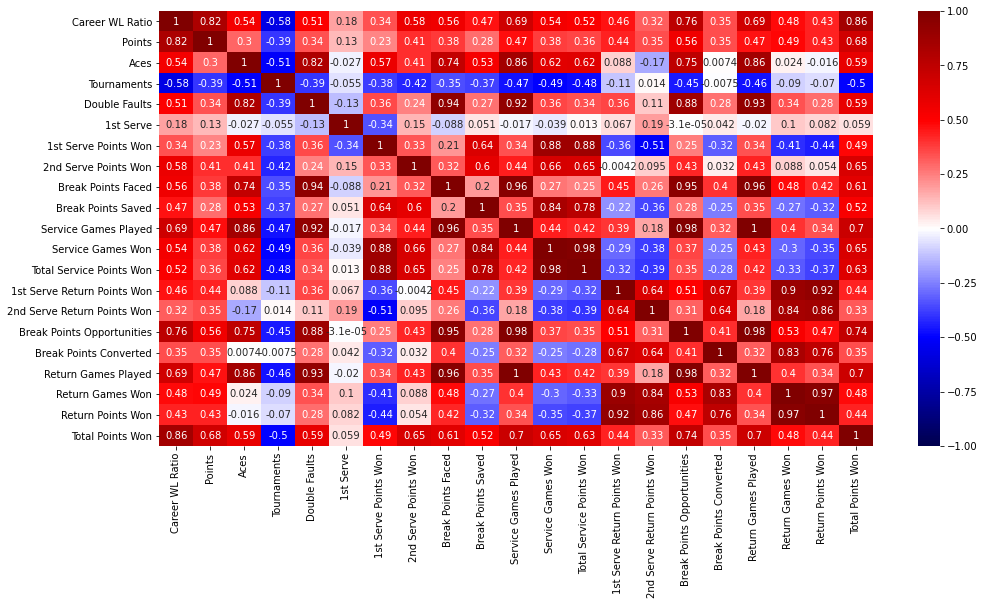

In [23]:
plt.figure(figsize=(16, 8))
sns.heatmap(tennis_o_wlratio.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

It's interesting how being in a tournament actually hurts WL ratio: the more challenging tournaments a player enters, the more he's likely to lose.

In [24]:
# Let's try a 0.55 threshold for using features:
print(tennis_o_wlratio.corr()['Career WL Ratio'].sort_values(ascending = False))

Career WL Ratio                1.000000
Total Points Won               0.859081
Points                         0.822180
Break Points Opportunities     0.761501
Service Games Played           0.693459
Return Games Played            0.686703
2nd Serve Points Won           0.576420
Break Points Faced             0.561890
Aces                           0.544893
Service Games Won              0.539090
Total Service Points Won       0.520432
Double Faults                  0.512263
Return Games Won               0.483829
Break Points Saved             0.467674
1st Serve Return Points Won    0.461117
Return Points Won              0.434593
Break Points Converted         0.345039
1st Serve Points Won           0.342541
2nd Serve Return Points Won    0.319305
1st Serve                      0.183614
Tournaments                   -0.575555
Name: Career WL Ratio, dtype: float64


In [25]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(tennis_o_wlratio, height=6, aspect=1.5);
# Service games played and aces have higher variability

Error in callback <function flush_figures at 0x7ffb22960160> (for post_execute):


KeyboardInterrupt: 

### First attempt at linear regression with scikit-learn:

In [26]:
import statsmodels.api as sm
import sklearn
from sklearn.linear_model import LinearRegression

%matplotlib inline

tennis_o_wlratio.columns

Index(['Career WL Ratio', 'Points', 'Aces', 'Tournaments', 'Double Faults',
       '1st Serve', '1st Serve Points Won', '2nd Serve Points Won',
       'Break Points Faced', 'Break Points Saved', 'Service Games Played',
       'Service Games Won', 'Total Service Points Won',
       '1st Serve Return Points Won', '2nd Serve Return Points Won',
       'Break Points Opportunities', 'Break Points Converted',
       'Return Games Played', 'Return Games Won', 'Return Points Won',
       'Total Points Won'],
      dtype='object')

In [29]:
from sklearn.metrics import mean_squared_error
# Create an empty model
lr = LinearRegression()

"""
Career WL Ratio                1.000000
Total Points Won               0.859081
Points                         0.822180
Break Points Opportunities     0.761501
Service Games Played           0.693459
Return Games Played            0.686703
2nd Serve Points Won           0.576420
Break Points Faced             0.561890
Aces                           0.544893
Tournaments                   -0.575555
"""

# Choose the response variable (will try others after)
X = tennis_o_wlratio.loc[:, ['Total Points Won', 'Points', 'Break Points Opportunities', 'Service Games Played', '2nd Serve Points Won', 'Break Points Faced', 'Aces', 'Tournaments']]
y = tennis_o_wlratio['Career WL Ratio']

lr.fit(X, y)

# Score
print("R^2: " + str(lr.score(X, y)))
print(np.sqrt(mean_squared_error(y, lr.predict(X))))

R^2: 0.946324645810174
0.1723999302081868


### Now with statsmodels:

In [13]:
sm.add_constant(X).head()
#Create the model
model = sm.OLS(y, sm.add_constant(X)) 
#Fit
fit = model.fit()
#Print out summary
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Career WL Ratio   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     200.5
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           2.43e-54
Time:                        21:23:24   Log-Likelihood:                 33.900
No. Observations:                 100   AIC:                            -49.80
Df Residuals:                      91   BIC:                            -26.35
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -6.3257      1.254     -5.044      0.000      -8.817      -3.835
Total Points Won              14.4217      2.891      4.988      0.000       8.679      20.165
Points                      9.014e-05   1.61e-05      5.597      0.000    5.81e-05       0.000
Break Points Opportunities     0.0005      0.000      4.908      0.000       0.000       0.001
Service Games Played       -4.843e-05      0.000     -0.448      0.655      -0.000       0.000
2nd Serve Points Won           0.9263      1.163      0.797      0.428      -1.384       3.236
Break Points Faced            -0.0004   7.63e-05     -5.790      0.000      -0.001      -0.000
Aces                        1.417e-05   4.43e-05      0.320      0.750   -7.38e-05       0.000
Tournaments                   -0.0157      0.006     -2.844      0.006      -0.027      -0.005
==============================================================================
Omnibus:                       18.178   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.432
Skew:                           0.697   Prob(JB):                     2.02e-08
Kurtosis:                       5.562   Cond. No.                     1.28e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Pretty good! But I think we can do better.

### Let's split up our train-test-eval split:

In [30]:
from sklearn.model_selection import train_test_split

# split, and don't touch:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
m = LinearRegression()
m.fit(X_train,y_train)
print(m.score(X_train,y_train))

# Try 4 fold data split for CV, yielding train, test, and eval (only train and test at present, with 100 players)

0.9382519780278454


In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

"""
# Step through degrees from 0 to 9 and store the training and test (generalization) error.
train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')
plt.ylim((0.0, 1e0))
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='upper left')
"""

"\n# Step through degrees from 0 to 9 and store the training and test (generalization) error.\ntrain_error = np.empty(10)\ntest_error = np.empty(10)\nfor degree in range(10):\n    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())\n    est.fit(X_train, y_train)\n    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))\n    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))\n\n# Plot the training and test errors against degree\nplt.figure(figsize=(8,6))\nplt.plot(np.arange(10), train_error, color='green', label='train')\nplt.plot(np.arange(10), test_error, color='red', label='test')\nplt.ylim((0.0, 1e0))\nplt.ylabel('log(mean squared error)')\nplt.xlabel('degree')\nplt.legend(loc='upper left')\n"

*Still decent, only a little overfitting.*
### Let's try Lasso and see which features we can eliminate:

In [34]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state = 42)
cv_lm_r2s, cv_lm_reg_r2s = [], []
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
# X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

# Needs regularization, I think, and test and train sets are not accessible using above function
for i in range(-15,-1):
    m = Lasso(alpha=10**i, max_iter = 2000)
    m.fit(X_train_scaled,y_train)
    print(np.sqrt(mean_squared_error(y_test, m.predict(X_test_scaled))))

0.25597905194915227
0.2559790519491366
0.2559790519489736
0.2559790519473395
0.25597905193100046
0.25597905176762187
0.2559790501338332
0.25597903379605774
0.2559788704288673
0.25597723781407117
0.2559610173839582
0.25607519692855424
0.2581001621617003
0.2851846679959472


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1741603629530812, tolerance: 0.003803068836279225
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1741603572500336, tolerance: 0.003803068836279225
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1741603002194214, tolerance: 0.003803068836279225
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/li

Looks like 10^-4 is the ideal alpha. Need to look at coefficients.

### And for Ridge:

In [35]:
for i in range(-10,5):
    m = Ridge(alpha=10**i)
    m.fit(X_train_scaled,y_train)
    print(m.coef_,m.score(X_test_scaled,y_test))
    print("RMSE: "+str(np.sqrt(mean_squared_error(y_train, m.predict(X_train_scaled))))+"/n")

[ 0.23027318  0.12222514  1.01425165 -0.02138778  0.0054652  -0.78557682
  0.00693631 -0.05342076] 0.943616682031609
RMSE: 0.17133008275846728/n
[ 0.23027318  0.12222514  1.01425165 -0.02138778  0.0054652  -0.78557682
  0.00693631 -0.05342076] 0.9436166820285844
RMSE: 0.17133008275846728/n
[ 0.23027318  0.12222514  1.01425163 -0.02138776  0.0054652  -0.78557683
  0.00693631 -0.05342076] 0.9436166819983399
RMSE: 0.1713300827584673/n
[ 0.23027319  0.12222515  1.01425147 -0.02138754  0.0054652  -0.78557685
  0.00693626 -0.05342076] 0.9436166816958932
RMSE: 0.17133008275846784/n
[ 0.23027327  0.12222522  1.01424986 -0.02138534  0.00546513 -0.78557709
  0.00693574 -0.05342078] 0.9436166786713747
RMSE: 0.17133008275852676/n
[ 0.23027403  0.12222591  1.01423378 -0.02136333  0.00546444 -0.78557948
  0.00693058 -0.05342096] 0.9436166484210301
RMSE: 0.1713300827644157/n
[ 0.23028165  0.12223283  1.01407304 -0.02114347  0.0054576  -0.78560334
  0.00687897 -0.05342276] 0.9436163454023121
RMSE: 0.1

Looks like 0.981 is our highest result on the test set, using Ridge with an alpha of 10^-10. Only feature 4 seems extraneous. Let's iterate by dropping them, identifying them as colinear.

In [68]:
# Create an empty model
lr = LinearRegression()

# Choose the response variable (will try others after)
X = tennis_df_subset.loc[:, ['Total Points Won', 'Points', 'Break Points Opportunities', 'Service Games Played', 'Break Points Faced', 'Aces', 'Tournaments']]
y = tennis_df_subset['Career WL Ratio']
lr.fit(X, y)

# Score
print("R^2: " + str(lr.score(X, y)))

R^2: 0.9459504044497102


Not bad for such a simple model, but also not quite as good as our previous R^2 of 95.8%.

In [ ]:
sm.add_constant(X).head()
model = sm.OLS(y, sm.add_constant(X)) 
fit = model.fit()
fit.summary()

In [ ]:
cv_lm_r2s, cv_lm_reg_r2s, cv_lm_poly = [], [], [] #collect the validation results for both models

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

m = RidgeCV()
m.fit(X,y)
print(m.coef_,m.score(X_test,y_test))

In [ ]:
m = LassoCV()
m.fit(X,y)
print(m.coef_,m.score(X_test,y_test))

In [ ]:
#examine Djokovich or Federer

In [ ]:
X = tennis_df_subset.loc[:, ['Tournaments', '2nd Serve Points Won', 'Total Points Won']]
y = tennis_df_subset['Career WL Ratio']
lr.fit(X, y)

# Score
print("R^2: " + str(lr.score(X, y)))

In [86]:
"""
plt.scatter(tennis_df_subset['2nd Serve Points Won'],y)
plt.scatter(X,m.predict(X))
"""
# Plot the residuals, randomly scattered, no patterns
# Calculate RMSE on scale of target variable, WL Ratio

"\nplt.scatter(tennis_df_subset['2nd Serve Points Won'],y)\nplt.scatter(X,m.predict(X))\n"

## Deliverable/communication:

 * organized project repository
 * slide presentation
 * visual and oral communication in presentations
 * write-up of process and results

### Design:

 * iterative design process
 * "MVP"s and building outward
 * [stand-ups/scrums](https://en.wikipedia.org/wiki/Scrum_(software_development)) (1 minute progress updates to the class)